## Here we are trying to get a even better prediction coming from the baseline models we have done
In other words, we can possible improve the linear regression model by putting some quadratic terms in it
based on the age and some other factors that are not so linear with the target variable.
Furthermore, we might be able to improve the gradient boost model, by choosing the depth appropriatly.  

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import numpy as np
import warnings
from pandas.api.types import is_numeric_dtype
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import scipy.stats as stats
import statsmodels.api as sm

In [156]:
import importlib
import sys
import os
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))

print(parent_dir)
sys.path.insert(0,parent_dir)
import data_manipulation.data_transform as dat

importlib.reload(dat)

/home/cody/Documents/DataSciBC/EPLTransfer


<module 'data_manipulation.data_transform' from '/home/cody/Documents/DataSciBC/EPLTransfer/data_manipulation/data_transform.py'>

In [157]:
main_data_path = "../../data/main_data/train/train.csv"
train = pd.read_csv(main_data_path)
train_data = dat.transformer(train,EDA=False).data

In [158]:
train_data.head()

,name,height,market_value,adjusted_market_value,team,league,minutesPlayed,totalLongBalls,keyPass,totalPass,...,xGChain,xGBuildup,age,pos_D,pos_F,pos_G,pos_M,foot_both,foot_left,foot_right
0,noah mbamba,187.0,3000000.0,3000000,Bayer 04 Leverkusen,Bundesliga,613,21,4,330,...,0.000000,0.000000,19.0,True,False,False,False,False,False,True
1,zachary duncan,183.0,300000.0,367916,AGF,Superligaen,956,41,7,332,...,0.000000,0.000000,21.0,False,False,False,True,False,False,True
2,manuel neuer,193.0,4000000.0,4000000,FC Bayern München,Bundesliga,20059,2421,2,7617,...,0.271096,0.270107,38.0,False,False,True,False,False,False,True
3,mickel miller,173.0,250000.0,250000,Plymouth Argyle,Championship,2290,89,29,809,...,0.000000,0.000000,28.0,False,False,False,True,False,True,False
4,gaetano monachello,185.0,900000.0,1191864,Atalanta,Serie A,355,5,0,70,...,0.161218,0.061587,22.0,False,True,False,False,False,True,False


In [159]:
def scale_back(x):
    #return np.expm1(x)
    return x

In [160]:
train_data.columns

Index(['name', 'height', 'market_value', 'adjusted_market_value', 'team',
       'league', 'minutesPlayed', 'totalLongBalls', 'keyPass', 'totalPass',
       'totalCross', 'goalAssist', 'savedShotsFromInsideTheBox', 'saves',
       'totalKeeperSweeper', 'goalsPrevented', 'touches', 'possessionLostCtrl',
       'dispossessed', 'aerialLost', 'aerialWon', 'duelLost', 'duelWon',
       'challengeLost', 'outfielderBlock', 'totalContest', 'interceptionWon',
       'wonContest', 'totalTackle', 'totalClearance', 'blockedScoringAttempt',
       'hitWoodwork', 'bigChanceCreated', 'bigChanceMissed', 'shotOffTarget',
       'onTargetScoringAttempt', 'goals', 'wasFouled', 'fouls', 'totalOffside',
       'yellow_card', 'red_card', 'rating', 'accuratePass',
       'accurateLongBalls', 'accurateCross', 'accurateKeeperSweeper',
       'expectedAssists', 'expectedGoals', 'xGChain', 'xGBuildup', 'age',
       'pos_D', 'pos_F', 'pos_G', 'pos_M', 'foot_both', 'foot_left',
       'foot_right'],
      dtype='

In [2]:
features = ['minutesPlayed', 'totalLongBalls', 'keyPass', 'totalPass',
       'totalCross', 'goalAssist', 'savedShotsFromInsideTheBox', 'saves',
       'totalKeeperSweeper', 'goalsPrevented', 'touches', 'possessionLostCtrl',
       'dispossessed', 'aerialLost', 'aerialWon', 'duelLost', 'duelWon',
       'challengeLost', 'outfielderBlock', 'totalContest', 'interceptionWon',
       'wonContest', 'totalTackle', 'totalClearance', 'blockedScoringAttempt',
       'hitWoodwork', 'bigChanceCreated', 'bigChanceMissed', 'shotOffTarget',
       'onTargetScoringAttempt', 'goals', 'wasFouled', 'fouls', 'totalOffside',
       'yellow_card', 'red_card', 'rating', 'accuratePass',
       'accurateLongBalls', 'accurateCross', 'accurateKeeperSweeper',
       'expectedAssists', 'expectedGoals', 'xGChain', 'xGBuildup', 'age',
       'pos_D', 'pos_F', 'pos_G', 'pos_M', 'foot_both', 'foot_left',
       'foot_right']
target = 'adjusted_market_value'


In [162]:
# Linear Regression
# lets do a k-fold cross validation.
cv = KFold(n_splits=10,shuffle=True,random_state=42,)
X = train_data[features]
y = train_data[target]

train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = LinearRegression()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 49961930100825.71 std: 1766190834328.662
MSE for test:  mean: 52623128336151.76  std: 16157787424203.045

RMSE for train: mean: 7067261.791999064 std: 125462.60070582716
RMSE for test: mean: 7167938.0340295015 std: 1115254.5343844378

R^2 for train: mean: 0.4080075808979379 std: 0.006344560557093116
R^2 for test: mean: 0.3709262457835678 std: 0.07693190732989633

MAE for train: mean: 3607039.4571535764 std: 52779.976526211336
MAE for test: mean: 3660546.333153973 std: 185378.77754387652

MAPE for train: mean: 4.104013257779082 std: 0.05894752588706118
MAPE for test: mean: 4.1451680329698934 std: 0.5716244798784486



We should just scale the data using log, as it really makes it hard to determine how well it is doing.
But, doing a baseline model, we can see that the RMSE \approx 7million EUR for both train and test.  But, it seems that this model does not explain the variance in the depedent variable as we have a low R^2, meaning it is getting close to just approximating using the mean.

In [163]:
# Now lets add in the square root of age and see what that does.

train_data_sqrt = train_data.copy()
train_data_sqrt['age2'] = np.pow(train_data_sqrt['age'],2)
train_data_sqrt['rating2'] = np.pow(train_data_sqrt['rating'],2)
train_data_sqrt['rating3'] = np.pow(train_data_sqrt['rating'],3)

features_sqrt = ['minutesPlayed', 'totalLongBalls', 'keyPass', 'totalPass',
       'totalCross', 'goalAssist', 'savedShotsFromInsideTheBox', 'saves',
       'totalKeeperSweeper', 'goalsPrevented', 'touches', 'possessionLostCtrl',
       'dispossessed', 'aerialLost', 'aerialWon', 'duelLost', 'duelWon',
       'challengeLost', 'outfielderBlock', 'totalContest', 'interceptionWon',
       'wonContest', 'totalTackle', 'totalClearance', 'blockedScoringAttempt',
       'hitWoodwork', 'bigChanceCreated', 'bigChanceMissed', 'shotOffTarget',
       'onTargetScoringAttempt', 'goals', 'wasFouled', 'fouls', 'totalOffside',
       'yellow_card', 'red_card', 'rating','rating2','rating3', 'accuratePass',
       'accurateLongBalls', 'accurateCross', 'accurateKeeperSweeper',
       'expectedAssists', 'expectedGoals', 'xGChain', 'xGBuildup', 'age','age2',
       'pos_D', 'pos_F', 'pos_G', 'pos_M', 'foot_both', 'foot_left',
       'foot_right']
target_sqrt = 'adjusted_market_value'  

In [164]:
# Linear Regression
# lets do a k-fold cross validation.
cv = KFold(n_splits=10,shuffle=True,random_state=42,)
X = train_data_sqrt[features_sqrt]
y = train_data_sqrt[target_sqrt]

train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = LinearRegression()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 49473249249220.8 std: 1756654023801.3716
MSE for test:  mean: 52086270938926.516  std: 16065874971963.672

RMSE for train: mean: 7032603.467106437 std: 125450.08434955757
RMSE for test: mean: 7131144.606295528 std: 1110426.7391542455

R^2 for train: mean: 0.4137999024696519 std: 0.006437661339685032
R^2 for test: mean: 0.37711061702079773 std: 0.07777155738779248

MAE for train: mean: 3578601.0959955463 std: 53870.46176209649
MAE for test: mean: 3632906.594980958 std: 190198.16620568113

MAPE for train: mean: 4.122877873370021 std: 0.07213803045653065
MAPE for test: mean: 4.170964586903621 std: 0.6383736250333496



In [165]:
# Lets look at the Residues as see what is happening.
# First build a model and fit it.
reg = LinearRegression()
reg.fit(train_data_sqrt[features_sqrt],train_data[target_sqrt])
resid = train_data_sqrt.copy()
resid['residuals']= np.abs(reg.predict(train_data_sqrt[features_sqrt]) - train_data[target_sqrt])
resid['prediction'] = reg.predict(train_data_sqrt[features_sqrt])
test=resid[['name','adjusted_market_value','pos_D','pos_M','pos_F','pos_G','team','league','residuals','prediction']]
test


,name,adjusted_market_value,pos_D,pos_M,pos_F,pos_G,team,league,residuals,prediction
0,noah mbamba,3000000,True,False,False,False,Bayer 04 Leverkusen,Bundesliga,1.557628e+06,1.442372e+06
1,zachary duncan,367916,False,True,False,False,AGF,Superligaen,1.405706e+06,1.773622e+06
2,manuel neuer,4000000,False,False,False,True,FC Bayern München,Bundesliga,7.761609e+06,1.176161e+07
3,mickel miller,250000,False,True,False,False,Plymouth Argyle,Championship,1.942075e+04,2.694207e+05
4,gaetano monachello,1191864,False,False,True,False,Atalanta,Serie A,4.718777e+06,5.910641e+06
...,...,...,...,...,...,...,...,...,...,...
9362,michael svoboda,1500000,True,False,False,False,Venezia,Serie A,3.336433e+06,4.836433e+06
9363,kalifa coulibaly,1742433,False,False,True,False,Nantes,Ligue 1,2.188684e+06,3.931117e+06
9364,nordin jackers,900000,False,False,False,True,Club Brugge KV,"First Division A, Championship Round",2.406986e+06,3.306986e+06
9365,mads kikkenborg,845068,False,False,False,True,Lyngby,Superligaen,2.843699e+06,3.688767e+06


In [ ]:
test

Looking at the above dataframe, we can see that the outliers, the top players in the world are off by a lot.  In other words, the outliers are too big and hence can not be predicted as easily.  This 

In [82]:
# Finally, lets try XGBoost
# lets do a k-fold cross validation.
cv = KFold(n_splits=10,shuffle=True,random_state=42)
X = train_data_sqrt[features_sqrt]
y = train_data_sqrt[target_sqrt]

train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = XGBRegressor()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(y_train,y_train_pred))
    test_mses.append(mean_squared_error(y_val,y_test_pred))

    train_rmses.append(root_mean_squared_error(y_train,y_train_pred))
    test_rmses.append(root_mean_squared_error(y_val,y_test_pred))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(y_train,y_train_pred))
    test_maes.append(mean_absolute_error(y_val,y_test_pred))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 1141806142675.239 std: 51701778702.10566
MSE for test:  mean: 31854529003885.676  std: 8074725246676.548

RMSE for train: mean: 1068281.5219509306 std: 24098.392756418496
RMSE for test: mean: 5598977.136293719 std: 711325.5451239357

R^2 for train: mean: 0.9864698231220246 std: 0.0004378358118645253
R^2 for test: mean: 0.6082847356796265 std: 0.07578602751005648

MAE for train: mean: 684392.7968402265 std: 11786.60782578083
MAE for test: mean: 2404684.0852141688 std: 160400.30858635824

MAPE for train: mean: 0.7641163808855408 std: 0.010475752744088122
MAPE for test: mean: 1.4715200171682796 std: 0.08787736252723263



In [83]:
# Lets Try Gradient Boosting Regression
# lets do a k-fold cross validation.
cv = KFold(n_splits=10,shuffle=True,random_state=42)
X = train_data_sqrt[features_sqrt]
y = train_data_sqrt[target_sqrt]

train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = GradientBoostingRegressor()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(y_train,y_train_pred))
    test_mses.append(mean_squared_error(y_val,y_test_pred))

    train_rmses.append(root_mean_squared_error(y_train,y_train_pred))
    test_rmses.append(root_mean_squared_error(y_val,y_test_pred))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(y_train,y_train_pred))
    test_maes.append(mean_absolute_error(y_val,y_test_pred))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')   

MSE for train: mean: 15697945466472.23 std: 256359460285.9835
MSE for test:  mean: 31873275379835.76  std: 7793561964590.77

RMSE for train: mean: 3961932.407912822 std: 32203.44084621446
RMSE for test: mean: 5599428.667375373 std: 720884.1646274516

R^2 for train: mean: 0.8138320507860234 std: 0.005592458969156622
R^2 for test: mean: 0.6099134699922313 std: 0.07051626213006884

MAE for train: mean: 2013323.906202623 std: 18054.619079549862
MAE for test: mean: 2417391.295539856 std: 154888.0280265306

MAPE for train: mean: 1.5721180394517427 std: 0.028435893491220943
MAPE for test: mean: 1.6893394221612374 std: 0.1788407827965807



In [4]:
# Lets look at specific positions and see if we can improve the models for them.
import sys
import os
sys.path.insert(0,os.path.abspath('../models'))
import models.linear_regression as lr
import importlib
importlib.reload(lr)


ModuleNotFoundError: No module named 'models'

In [109]:
# Linear Regression
# lets do a k-fold cross validation.
features_D = features_sqrt.copy()
features_D.remove('pos_M')
features_D.remove('pos_F')
features_D.remove('pos_G')

cv = KFold(n_splits=10,shuffle=True,random_state=42,)

X = train_data_sqrt[train_data_sqrt['pos_D'] == True][features_D]

y = train_data_sqrt[train_data_sqrt['pos_D'] == True][target_sqrt]


train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data_sqrt[train_data_sqrt['pos_D']==True]):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = LinearRegression()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 28652242615639.137 std: 1162341011764.8174
MSE for test:  mean: 31010580303612.574  std: 10715475568019.64

RMSE for train: mean: 5351671.0895298775 std: 108899.79398161604
RMSE for test: mean: 5479887.649491749 std: 990662.22929936

R^2 for train: mean: 0.45656716552627036 std: 0.005829470664716239
R^2 for test: mean: 0.4074581689643195 std: 0.06369789776513594

MAE for train: mean: 3067606.4090700545 std: 60957.74775328073
MAE for test: mean: 3159936.1991300094 std: 328028.9535436971

MAPE for train: mean: 3.577330990846786 std: 0.09324222324607032
MAPE for test: mean: 3.6110371644983665 std: 0.2972694497844626



In [111]:
# Linear Regression
# lets do a k-fold cross validation.
features_F = features_sqrt.copy()
features_F.remove('pos_D')
features_F.remove('pos_M')
features_F.remove('pos_G')

cv = KFold(n_splits=10,shuffle=True,random_state=42,)

X = train_data_sqrt[train_data_sqrt['pos_F'] == True][features_F]

y = train_data_sqrt[train_data_sqrt['pos_F'] == True][target_sqrt]


train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data_sqrt[train_data_sqrt['pos_F']==True]):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = LinearRegression()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 68647513169929.77 std: 5250063039841.275
MSE for test:  mean: 84025943684487.8  std: 53409569490481.84

RMSE for train: mean: 8278841.676183102 std: 329080.0368049408
RMSE for test: mean: 8808107.258856608 std: 2538343.9879112816

R^2 for train: mean: 0.480177288203553 std: 0.0070219100501881454
R^2 for test: mean: 0.3274145948395355 std: 0.140722811048793

MAE for train: mean: 4278817.544655176 std: 117880.63608611384
MAE for test: mean: 4535067.86144729 std: 429643.89769319905

MAPE for train: mean: 4.208581141856504 std: 0.13606938851201492
MAPE for test: mean: 4.388903957735226 std: 0.5478436916824729



In [112]:
# Linear Regression
# lets do a k-fold cross validation.
features_M = features_sqrt.copy()
features_M.remove('pos_D')
features_M.remove('pos_F')
features_M.remove('pos_G')

cv = KFold(n_splits=10,shuffle=True,random_state=42,)

X = train_data_sqrt[train_data_sqrt['pos_M'] == True][features_M]

y = train_data_sqrt[train_data_sqrt['pos_M'] == True][target_sqrt]


train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data_sqrt[train_data_sqrt['pos_M']==True]):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = LinearRegression()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 54095656115773.76 std: 2187061684033.405
MSE for test:  mean: 58192893327078.11  std: 20010416063519.93

RMSE for train: mean: 7353453.90134079 std: 149572.17866188777
RMSE for test: mean: 7518731.026369661 std: 1289021.7531850822

R^2 for train: mean: 0.4205818598518004 std: 0.007152068739010185
R^2 for test: mean: 0.38048964396993296 std: 0.06231652006991503

MAE for train: mean: 3776924.02911826 std: 60187.2624349347
MAE for test: mean: 3888848.0502282074 std: 234724.84128347746

MAPE for train: mean: 4.110096423485499 std: 0.08216489985701222
MAPE for test: mean: 4.214448612850028 std: 0.681370048666754



In [113]:
# Linear Regression
# lets do a k-fold cross validation.
features_G = features_sqrt.copy()
features_G.remove('pos_D')
features_G.remove('pos_F')
features_G.remove('pos_M')

cv = KFold(n_splits=10,shuffle=True,random_state=42,)

X = train_data_sqrt[train_data_sqrt['pos_G'] == True][features_G]

y = train_data_sqrt[train_data_sqrt['pos_G'] == True][target_sqrt]


train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data_sqrt[train_data_sqrt['pos_G']==True]):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = LinearRegression()

    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 15148449360836.525 std: 916296785879.5227
MSE for test:  mean: 21923795671148.32  std: 9272446838459.55

RMSE for train: mean: 3890312.75817843 std: 117966.11543428493
RMSE for test: mean: 4560718.463158802 std: 1060020.1747847684

R^2 for train: mean: 0.47861651958886886 std: 0.015242313689695454
R^2 for test: mean: 0.06805695297657358 std: 0.43396749162997766

MAE for train: mean: 2225754.6223483467 std: 60818.37978813171
MAE for test: mean: 2583135.6076816386 std: 337197.06787638

MAPE for train: mean: 3.924952803884169 std: 0.08115483363570408
MAPE for test: mean: 4.3545092736395254 std: 0.8513494038700589



In [104]:
import sys
import os
sys.path.insert(1,os.path.abspath('../models'))
import models.decision_ensamble as de
import importlib
importlib.reload(de)
import warnings
warnings.filterwarnings('ignore')

In [105]:
model = de.ensamble_XGBR_LR(train_data[features],train_data[target],6,0)
y_pred = model.predict(train_data[features])
mse = root_mean_squared_error(y_pred,train_data[target])

In [106]:
print(mse)

2911179.862888246


In [111]:
cv = KFold(n_splits=10,shuffle=True,random_state=42,)
X = train_data[features]
y = train_data[target]

train_mses = []
train_rmses = []
train_R2 = []
train_maes = []
train_mapes = []


test_mses = []
test_rmses = []
test_R2 = []
test_maes = []
test_mapes = []

for train_index, val_index in cv.split(train_data):
    X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    model = de.ensamble_XGBR_LR(X_train,y_train, 2, 2)
    

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
    test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

    train_R2.append(r2_score(y_train,y_train_pred))
    test_R2.append(r2_score(y_val,y_test_pred))

    train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
    test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

    train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
    test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

MSE for train: mean: 29402483813451.24 std: 963852860168.9414
MSE for test:  mean: 42890488967721.26  std: 14988880568146.746

RMSE for train: mean: 5421677.885490996 std: 88840.97832153503
RMSE for test: mean: 6456576.93077073 std: 1096860.6587714215

R^2 for train: mean: 0.6515530910694771 std: 0.005769611531451017
R^2 for test: mean: 0.46362566901382624 std: 0.22063196979206404

MAE for train: mean: 2783664.857110725 std: 31944.591605377096
MAE for test: mean: 3018615.808968709 std: 227734.26898980912

MAPE for train: mean: 2.746964186463026 std: 0.03744867966384481
MAPE for test: mean: 2.942388671936376 std: 0.5077483902917114



In [108]:
cv = KFold(n_splits=10,shuffle=True,random_state=42,)
X = train_data[features]
y = train_data[target]

tree_depth = [1,2,3,4,5,6]
alpha_m = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]

for i in range(len(tree_depth)):
    for j in range(len(alpha_m)):

        train_mses = []
        train_rmses = []
        train_R2 = []
        train_maes = []
        train_mapes = []


        test_mses = []
        test_rmses = []
        test_R2 = []
        test_maes = []
        test_mapes = []

        for train_index, val_index in cv.split(train_data):
            X_train, X_val = X.iloc[train_index] , X.iloc[val_index]
            y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

            model = de.ensamble_XGBR_LR(X_train,y_train, 3, 0)
            

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_val)

            train_mses.append(mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
            test_mses.append(mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

            train_rmses.append(root_mean_squared_error(scale_back(y_train),scale_back(y_train_pred)))
            test_rmses.append(root_mean_squared_error(scale_back(y_val),scale_back(y_test_pred)))

            train_R2.append(r2_score(y_train,y_train_pred))
            test_R2.append(r2_score(y_val,y_test_pred))

            train_maes.append(mean_absolute_error(scale_back(y_train),scale_back(y_train_pred)))
            test_maes.append(mean_absolute_error(scale_back(y_val),scale_back(y_test_pred)))

            train_mapes.append(mean_absolute_percentage_error(y_train,y_train_pred))
            test_mapes.append(mean_absolute_percentage_error(y_val,y_test_pred))

        print(f'Stats for max_depth = {tree_depth[i]} and alpha = {alpha_m[j]}')
        print(f'MSE for train: mean: {np.mean(train_mses)} std: {np.std(train_mses)}') 
        print(f'MSE for test:  mean: {np.mean(test_mses)}  std: {np.std(test_mses)}\n')

        print(f'RMSE for train: mean: {np.mean(train_rmses)} std: {np.std(train_rmses)}') 
        print(f'RMSE for test: mean: {np.mean(test_rmses)} std: {np.std(test_rmses)}\n')

        print(f'R^2 for train: mean: {np.mean(train_R2)} std: {np.std(train_R2)}') 
        print(f'R^2 for test: mean: {np.mean(test_R2)} std: {np.std(test_R2)}\n')

        print(f'MAE for train: mean: {np.mean(train_maes)} std: {np.std(train_maes)}') 
        print(f'MAE for test: mean: {np.mean(test_maes)} std: {np.std(test_maes)}\n')  

        print(f'MAPE for train: mean: {np.mean(train_mapes)} std: {np.std(train_mapes)}') 
        print(f'MAPE for test: mean: {np.mean(test_mapes)} std: {np.std(test_mapes)}\n')

Stats for max_depth = 1 and alpha = 0.1
MSE for train: mean: 21131902681985.18 std: 1110488870030.0127
MSE for test:  mean: 2.1099215974313725e+35  std: 5.592259807084013e+35

RMSE for train: mean: 4595338.747757065 std: 121509.15746442757
RMSE for test: mean: 1.8816993674428448e+17 std: 4.1902772539390426e+17

R^2 for train: mean: 0.7495219119950087 std: 0.01179391084119454
R^2 for test: mean: -2.914422380496641e+21 std: 8.082614517369052e+21

MAE for train: mean: 2354434.6694467096 std: 29740.687061272685
MAE for test: mean: 8473873562710302.0 std: 2.0314445100782576e+16

MAPE for train: mean: 2.0299525540790517 std: 0.030797165358471462
MAPE for test: mean: 8401578719.274541 std: 18704486060.731915

Stats for max_depth = 1 and alpha = 0.2
MSE for train: mean: 21131902681985.18 std: 1110488870030.0127
MSE for test:  mean: 2.1099215974313725e+35  std: 5.592259807084013e+35

RMSE for train: mean: 4595338.747757065 std: 121509.15746442757
RMSE for test: mean: 1.8816993674428448e+17 std:

KeyboardInterrupt: 

In [146]:
import sys
import os
sys.path.insert(1,os.path.abspath('../models'))
import models.base_line_models as blm
import importlib
importlib.reload(blm)
import warnings
warnings.filterwarnings('ignore')

In [147]:
file_dir = '../../data/main_data/train/train.csv'
train = pd.read_csv(file_dir)
train.head()

,name,dob,pos,height,foot,date,market_value,adjusted_market_value,team,league,...,red_card,rating,accuratePass,accurateLongBalls,accurateCross,accurateKeeperSweeper,expectedAssists,expectedGoals,xGChain,xGBuildup
0,noah mbamba,2005-01-04,D,187.0,right,2024-02-03,3000000.0,3000000,Bayer 04 Leverkusen,Bundesliga,...,0.0,5.414286,13.523810,0.619048,0.047619,0.000000,0.025627,0.001195,0.000000,0.000000
1,zachary duncan,2000-05-29,M,183.0,right,2021-11-07,300000.0,367916,AGF,Superligaen,...,0.0,6.545833,9.000000,0.458333,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000
2,manuel neuer,1986-03-26,G,193.0,right,2024-10-19,4000000.0,4000000,FC Bayern München,Bundesliga,...,0.0,6.536864,27.122881,5.411017,0.000000,0.495763,0.001084,0.000969,0.271096,0.270107
3,mickel miller,1995-12-01,M,173.0,left,2024-04-12,250000.0,250000,Plymouth Argyle,Championship,...,0.0,6.551163,13.837209,0.697674,0.418605,0.000000,0.067950,0.015244,0.000000,0.000000
4,gaetano monachello,1994-03-02,F,185.0,left,2016-05-15,900000.0,1191864,Atalanta,Serie A,...,0.0,6.550000,5.700000,0.200000,0.100000,0.000000,0.000000,0.111925,0.161218,0.061587


In [148]:
olr = blm.Simple_Linear_Regression(train)
olr.perform_CV()

MSE for train: mean: 49961930100825.71 std: 1766190834328.662
MSE for test:  mean: 52623128336151.76  std: 16157787424203.045

RMSE for train: mean: 7067261.791999064 std: 125462.60070582716
RMSE for test: mean: 7167938.0340295015 std: 1115254.5343844378

R^2 for train: mean: 0.4080075808979379 std: 0.006344560557093116
R^2 for test: mean: 0.3709262457835678 std: 0.07693190732989633

MAE for train: mean: 3607039.4571535764 std: 52779.976526211336
MAE for test: mean: 3660546.333153973 std: 185378.77754387652

MAPE for train: mean: 4.104013257779082 std: 0.05894752588706118
MAPE for test: mean: 4.1451680329698934 std: 0.5716244798784486



In [166]:
qolr = blm.Poly_Linear_Regression(train,quad_f=['age','goals','rating','minutesPlayed'],cubic_f=['rating'])
qolr.perform_CV()

MSE for train: mean: 48166128628761.58 std: 1699470837833.7805
MSE for test:  mean: 51166639312246.375  std: 15485278214710.736

RMSE for train: mean: 6939090.564118053 std: 123088.47114724903
RMSE for test: mean: 7071835.172003189 std: 1075075.1658674916

R^2 for train: mean: 0.429290997668857 std: 0.005581688206440754
R^2 for test: mean: 0.38769413995233604 std: 0.06738740372938333

MAE for train: mean: 3598839.007960687 std: 52235.07377671352
MAE for test: mean: 3656589.195557993 std: 192045.36773243448

MAPE for train: mean: 3.946852821493205 std: 0.06541447350039999
MAPE for test: mean: 3.99729879590846 std: 0.5695498263472104



In [150]:
dtr = blm.Decision_Tree_Reg(train)
dtr.perform_CV()

MSE for train: mean: 38509023.58815471 std: 14954536.338339996
MSE for test:  mean: 70373933863194.66  std: 26488971586549.39

RMSE for train: mean: 6020.301174585208 std: 1504.9908157336608
RMSE for test: mean: 8256849.790827801 std: 1482688.5697615487

R^2 for train: mean: 0.9999995448809553 std: 1.754663615400618e-07
R^2 for test: mean: 0.1134639523049954 std: 0.3954139634811173

MAE for train: mean: 140.60669649501438 std: 43.845745611877845
MAE for test: mean: 3193209.771189136 std: 277815.2295442393

MAPE for train: mean: 0.0005679999265820826 std: 0.00015315518748678741
MAPE for test: mean: 1.6846136250851114 std: 0.1788003013571284



In [152]:
m_olr = blm.Simple_Linear_Regression()
m_olr.perform_CV()

KeyError: "['pos_D', 'pos_F', 'pos_G'] not in index"

In [20]:
import importlib
import sys
import os
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))

print(parent_dir)
sys.path.insert(0,parent_dir)
import data_manipulation.data_transform as dat

importlib.reload(dat)

/home/cody/Documents/DataSciBC/EPLTransfer


<module 'data_manipulation.data_transform' from '/home/cody/Documents/DataSciBC/EPLTransfer/data_manipulation/data_transform.py'>

In [114]:
from sklearn.cluster import KMeans,AffinityPropagation,MeanShift,SpectralClustering, AgglomerativeClustering,DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [284]:
fd = '../../data/main_data/train/train.csv'
train = pd.read_csv(fd)

n_clusters = 5
train_data = dat.transformer(train,EDA=False).data

#train_data['adjusted_market_value'] = np.log1p(train_data['adjusted_market_value'])

train_data_P = train_data[train_data['pos_M'] == True]
pipeline = Pipeline([('scaler',StandardScaler()),('kmeans',KMeans(n_clusters=n_clusters))])
clust = pipeline.fit_transform(train_data_P[features],train_data_P[target])
train_data_clust = train_data_P.copy()
train_data_clust['cluster'] = pipeline.predict(train_data_P[features])


In [285]:
display(train_data_clust)

,name,height,market_value,adjusted_market_value,team,league,minutesPlayed,totalLongBalls,keyPass,totalPass,totalCross,goalAssist,savedShotsFromInsideTheBox,saves,totalKeeperSweeper,goalsPrevented,touches,possessionLostCtrl,dispossessed,aerialLost,aerialWon,duelLost,duelWon,challengeLost,outfielderBlock,totalContest,interceptionWon,wonContest,totalTackle,totalClearance,blockedScoringAttempt,hitWoodwork,bigChanceCreated,bigChanceMissed,shotOffTarget,onTargetScoringAttempt,goals,wasFouled,fouls,totalOffside,yellow_card,red_card,rating,accuratePass,accurateLongBalls,accurateCross,accurateKeeperSweeper,expectedAssists,expectedGoals,xGChain,xGBuildup,age,pos_D,pos_F,pos_G,pos_M,foot_both,foot_left,foot_right,cluster
1,zachary duncan,183.0,300000.0,367916,AGF,Superligaen,956,41,7,332,10,0,0,0,0,0.0,500,171,11,27,14,79,60,10,0,13,18,7,25,8,5,0,0,0,3,1,0,14,26,0,0.0,0.0,6.545833,9.000000,0.458333,0.041667,0.0,0.000000,0.000000,0.000000,0.000000,21.0,False,False,False,True,False,False,True,0
3,mickel miller,173.0,250000.0,250000,Plymouth Argyle,Championship,2290,89,29,809,121,1,0,0,0,0.0,1608,506,43,64,29,240,168,27,3,99,36,47,57,50,9,1,3,1,11,4,1,35,57,7,0.0,0.0,6.551163,13.837209,0.697674,0.418605,0.0,0.067950,0.015244,0.000000,0.000000,28.0,False,False,False,True,False,True,False,1
7,sem scheperman,188.0,300000.0,300000,Heracles Almelo,Eredivisie,915,27,9,368,3,0,0,0,0,0.0,535,103,5,24,33,57,77,12,4,6,13,5,33,13,2,0,0,3,7,6,0,8,16,3,0.0,0.0,6.450000,10.535714,0.392857,0.000000,0.0,0.031921,0.049796,0.000000,0.000000,22.0,False,False,False,True,False,True,False,0
8,carlos carmona,177.0,1500000.0,1953627,Sporting Gijón,LaLiga,3176,97,52,1371,147,5,0,0,0,0.0,2183,245,60,81,56,358,254,99,7,66,46,26,118,16,13,1,1,3,16,20,10,55,90,16,9.0,2.0,6.568085,20.765957,0.638298,0.659574,0.0,0.079046,0.121174,0.262809,0.103702,29.0,False,False,False,True,False,False,True,1
11,lossemy karaboue,173.0,800000.0,1059435,Troyes,Ligue 1,2259,133,32,1211,62,2,0,0,0,0.0,1835,59,51,24,20,142,147,25,4,80,51,54,36,28,10,0,3,1,7,6,0,39,21,3,3.0,1.0,6.564516,31.903226,2.225806,0.290323,0.0,0.068720,0.037763,0.228694,0.145597,28.0,False,False,False,True,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,zidane iqbal,180.0,1000000.0,1000000,FC Utrecht,Eredivisie,787,59,9,538,4,0,0,0,0,0.0,691,120,18,7,3,50,50,12,2,16,9,11,24,13,2,0,1,0,2,1,0,12,8,0,0.0,0.0,6.347619,22.380952,1.809524,0.000000,0.0,0.020563,0.010581,0.000000,0.000000,21.0,False,False,False,True,False,False,True,0
9354,dzenis burnic,185.0,500000.0,640814,VfB Stuttgart,Bundesliga,394,20,6,336,11,0,0,0,0,0.0,397,37,2,1,2,29,14,6,0,6,6,1,10,5,3,0,0,0,4,0,0,1,15,0,3.0,1.0,6.200000,42.857143,1.714286,0.285714,0.0,0.051200,0.026108,0.151944,0.100547,19.0,False,False,False,True,False,True,False,1
9357,leonardo bittencourt,171.0,2500000.0,2500000,SV Werder Bremen,Bundesliga,12718,340,195,5080,407,22,0,0,0,0.0,8244,1826,125,199,86,1071,960,247,10,397,135,154,405,62,66,9,26,19,115,83,24,322,279,43,40.0,2.0,6.559809,18.559809,0.679426,0.449761,0.0,0.103081,0.124383,0.325726,0.142207,30.0,False,False,False,True,False,False,True,2
9359,maxime lopez,167.0,7500000.0,7500000,Fiorentina,Serie A,15060,755,264,12999,315,16,0,0,0,0.0,15128,1859,108,92,30,772,589,263,21,228,160,137,290,92,29,1,23,3,39,34,8,133,230,6,45.0,1.0,6.671491,51.697368,2.074561,0.399123,0.0,0.078474,0.034420,0.341844,0.280438,26.0,False,False,False,True,False,False,True,3


In [286]:
display(clust)

array([[ 1.55741492,  3.39435573, 17.88018989, 13.50416123,  7.48461543],
       [ 3.68544996,  3.00913829, 16.15232936, 12.08664657,  5.95920691],
       [ 2.68301488,  3.76623198, 17.72224482, 13.56717506,  7.56693288],
       ...,
       [14.46831554, 12.23600697,  6.78911898,  7.43982731,  8.14962932],
       [13.35963369, 10.97301183, 11.14917302,  6.44344759,  7.91143187],
       [ 1.87309462,  4.28345528, 18.3700457 , 14.30135989,  8.27090482]])

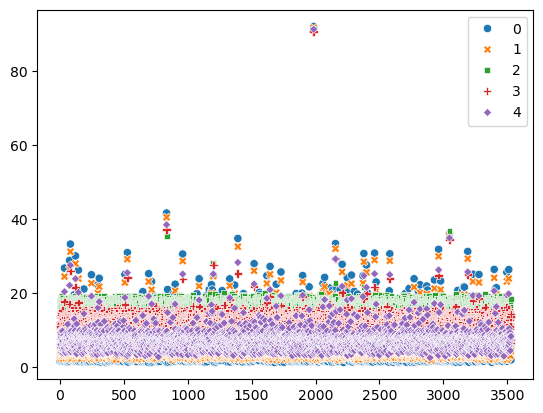

In [287]:
sns.scatterplot(clust,)
plt.show()

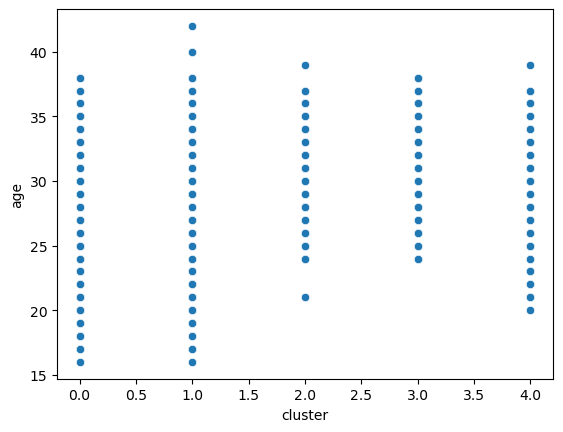

In [288]:
sns.scatterplot(train_data_clust,x='cluster',y='age')
plt.show()

In [289]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters)
train_data_clust['gmm_cluster'] = gmm.fit_predict(train_data_clust[features])

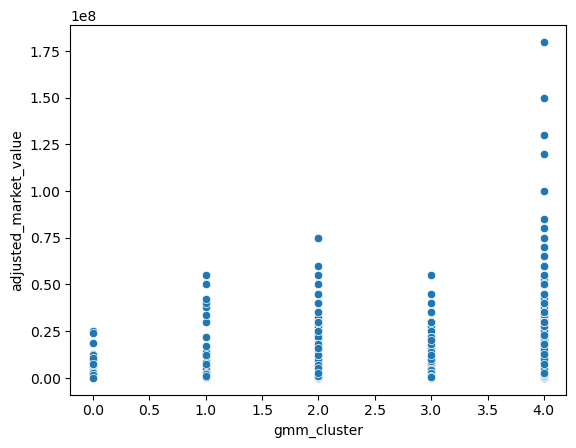

In [290]:
sns.scatterplot(train_data_clust, x='gmm_cluster',y='adjusted_market_value')
plt.show()

In [291]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=120, min_samples=5)  # You may need to adjust eps for your data
train_data_clust['dbscan_cluster'] = dbscan.fit_predict(train_data_P[features])

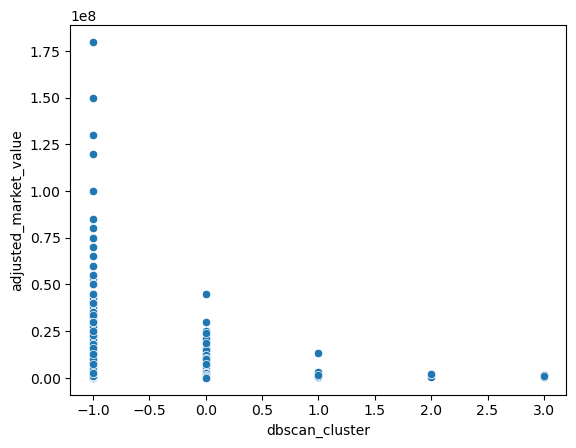

In [292]:
sns.scatterplot(train_data_clust, x='dbscan_cluster',y='adjusted_market_value')
plt.show()